# CALCUL AND PLOT ALTI DIAGS

In [1]:
import numpy as N
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import dask
from os import path
from dask.distributed import Client, LocalCluster, progress
import time
import dask_hpcconfig
import glob
from scipy import signal
from dask_jobqueue import PBSCluster
from tools_alti import *

import cartopy.io.shapereader as shpreader
import shapely.vectorized
import geopandas as gpd
from matplotlib.ticker import MaxNLocator


### USE PBSCLUSTER TO SET DASK SERVER

In [2]:
#HPCONFIG
#cluster = dask_hpcconfig.cluster("datarmor-local")
#overrides = {"cluster.n_workers": 10,"cluster.threads_per_worker":1}
#cluster = dask_hpcconfig.cluster("datarmor-local",**overrides)

#PBS
cluster = PBSCluster(processes=4,cores=4)
cluster.scale(jobs=4)
#cluster=dask_hpcconfig.cluster('datarmor')
print(cluster)

/home1/datahome/mcaillau/conda-env/pydask3/lib/python3.10/site-packages/dask_jobqueue/core.py:255: FutureWarning: job_extra has been renamed to job_extra_directives. You are still using it (even if only set to []; please also check config files). If you did not set job_extra_directives yet, job_extra will be respected for now, but it will be removed in a future release. If you already set job_extra_directives, job_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/home1/datahome/mcaillau/conda-env/pydask3/lib/python3.10/site-packages/dask_jobqueue/pbs.py:82: FutureWarning: project has been renamed to account as this kwarg was used wit -A option. You are still using it (please also check config files). If you did not set account yet, project will be respected for now, but it will be removed in a future release. If you already set account, project is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
INFO:distributed.scheduler:State start
INFO:

PBSCluster(f8325824, 'tcp://10.148.0.156:35948', workers=0, threads=0, memory=0 B)


### CONNECT TO THE CLUSTER
dashboards
https://datarmor-jupyterhub.ifremer.fr/user/mcaillau/proxy/127.0.0.1:8787

In [3]:
# explicitly connect to the cluster we just created
print(cluster)
print(cluster.dashboard_link)
client = Client(cluster)
print(client)


/home1/datahome/mcaillau/conda-env/pydask3/lib/python3.10/site-packages/dask_jobqueue/core.py:255: FutureWarning: job_extra has been renamed to job_extra_directives. You are still using it (even if only set to []; please also check config files). If you did not set job_extra_directives yet, job_extra will be respected for now, but it will be removed in a future release. If you already set job_extra_directives, job_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/home1/datahome/mcaillau/conda-env/pydask3/lib/python3.10/site-packages/dask_jobqueue/pbs.py:82: FutureWarning: project has been renamed to account as this kwarg was used wit -A option. You are still using it (please also check config files). If you did not set account yet, project will be respected for now, but it will be removed in a future release. If you already set account, project is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
INFO:distributed.scheduler:Receive client co

PBSCluster(f8325824, 'tcp://10.148.0.156:35948', workers=0, threads=0, memory=0 B)
http://10.148.0.156:8787/status
<Client: 'tcp://10.148.0.156:35948' processes=0 threads=0, memory=0 B>


In [4]:
lon_bnds=(14.2, 20.0)
lat_bnds=(32.4, 42.6)

### define chunks for the dataset : 
for Datarmor chunk must > 1gb

In [5]:
chunks={'time':600,'s_rho':-1,'xi_rho':865,'eta_rho':936}
grav=9.81
date_start="2012-06-01"
date_end="2013-08-01"
time_range=slice(date_start,date_end)

### Read croco results

In [6]:
path="/home/shom_simuref/CROCO/ODC/SIMU-RESULT/HINDCAST_2012_2013/OUTPUTS_201207_201307/"

In [7]:
ds=xr.open_mfdataset(path+'croco_his_surf_2*.nc', parallel=False,chunks=chunks,
                        concat_dim="time", combine="nested",
                        data_vars='minimal', coords='minimal', compat='override')
print('data size in GB {:0.2f}\n'.format(ds.nbytes / 1e9))


INFO:distributed.scheduler:Register worker <WorkerState 'tcp://10.148.0.97:56722', name: PBSCluster-3-2, status: init, memory: 0, processing: 0>
INFO:distributed.scheduler:Starting worker compute stream, tcp://10.148.0.97:56722
INFO:distributed.core:Starting established connection to tcp://10.148.0.97:42964
INFO:distributed.scheduler:Register worker <WorkerState 'tcp://10.148.0.97:40695', name: PBSCluster-3-0, status: init, memory: 0, processing: 0>
INFO:distributed.scheduler:Starting worker compute stream, tcp://10.148.0.97:40695
INFO:distributed.core:Starting established connection to tcp://10.148.0.97:42967
INFO:distributed.scheduler:Register worker <WorkerState 'tcp://10.148.0.97:41825', name: PBSCluster-3-3, status: init, memory: 0, processing: 0>
INFO:distributed.scheduler:Starting worker compute stream, tcp://10.148.0.97:41825
INFO:distributed.core:Starting established connection to tcp://10.148.0.97:42968
INFO:distributed.scheduler:Register worker <WorkerState 'tcp://10.148.0.9

data size in GB 425.54



#### keep only zeta

In [8]:
ds=ds.drop(['temp','salt','u','v'])


In [9]:
#remove duplicates time indexes
_,index=N.unique(ds.time,return_index=True)
ds=ds.isel(time=index)


#### select time range

In [10]:
ds=ds.sel(time=time_range)

In [11]:
#force chunk
ds=ds.chunk(chunks)

In [12]:
ds.zeta

<xarray.DataArray 'zeta' (time: 8760, eta_rho: 936, xi_rho: 2595)>
dask.array<rechunk-merge, shape=(8760, 936, 2595), dtype=float32, chunksize=(600, 936, 865), chunktype=numpy.ndarray>
Coordinates:
  * xi_rho   (xi_rho) float32 9.969e+36 9.969e+36 ... 9.969e+36 9.969e+36
  * eta_rho  (eta_rho) float32 9.969e+36 9.969e+36 ... 9.969e+36 9.969e+36
    lon_rho  (eta_rho, xi_rho) float32 dask.array<chunksize=(936, 865), meta=np.ndarray>
    lat_rho  (eta_rho, xi_rho) float32 dask.array<chunksize=(936, 865), meta=np.ndarray>
  * time     (time) datetime64[ns] 2012-07-01T13:00:00 ... 2013-07-01T12:00:00
Attributes:
    long_name:  SSH
    units:      m
    field:

#### add grid to the dataset

In [13]:
#read grid
ds_grid=xr.open_dataset('/home/shom_simuref/CROCO/ODC/CONFIGS/MEDITERRANEE_GLOBALE/CROCO_FILES/test2.nc')

In [14]:
#because of MPINOLAND add the non masked grid variables
for var in ["xi_rho","eta_rho","xi_u","eta_v","lon_rho","lat_rho","lon_u","lat_v"]:
    ds[var]=ds_grid[var]

In [15]:
ds['f']=ds_grid.f
ds['mask']=ds_grid.mask_rho
ds['dx']=1./ds_grid.pm
ds['dy']=1./ds_grid.pn
ds['xgrid']=ds_grid['x_rho']
ds['ygrid']=ds_grid['y_rho']


#### assign new grid to facilitate interpolation and/or area selection

In [16]:
coord_dict={"xi_rho":"X","eta_rho":"Y","xi_u":"X_U","eta_v":"Y_V"}
ds=ds.assign_coords({"X":ds_grid.lon_rho[0,:], "Y":ds_grid.lat_rho[:,0],"X_U":ds_grid.lon_u[0,:],"Y_V":ds_grid.lat_v[:,0]})
ds2=ds.swap_dims(coord_dict)
#ds2=ds2.sel(X=slice(*lon_bnds),X_U=slice(*lon_bnds),Y=slice(*lat_bnds),Y_V=slice(*lat_bnds))

### Coarsen CROCO  Grid

In [17]:
#ds3=ds2.interp(X=ds_aviso_grd.longitude,Y=ds_aviso_grd.latitude)
ds3=ds2.coarsen(X=3,Y=3,boundary="pad").mean()

/dev/shm/pbs.4288133.datarmor0/ipykernel_49225/391770638.py:2: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  ds3=ds2.coarsen(X=3,Y=3,boundary="pad").mean()


### rechunk to adjust to coarsen grid

In [18]:
zeta=ds3.zeta.chunk({"Y":-1,"X":-1,"time":2000})

In [19]:
zeta

<xarray.DataArray 'zeta' (time: 8760, Y: 312, X: 865)>
dask.array<rechunk-merge, shape=(8760, 312, 865), dtype=float32, chunksize=(2000, 312, 865), chunktype=numpy.ndarray>
Coordinates:
    xi_rho   (X) float64 dask.array<chunksize=(865,), meta=np.ndarray>
    eta_rho  (Y) float64 dask.array<chunksize=(312,), meta=np.ndarray>
  * time     (time) datetime64[ns] 2012-07-01T13:00:00 ... 2013-07-01T12:00:00
    lon_rho  (Y, X) float64 dask.array<chunksize=(312, 865), meta=np.ndarray>
    lat_rho  (Y, X) float64 dask.array<chunksize=(312, 865), meta=np.ndarray>
  * X        (X) float64 -6.983 -6.933 -6.883 -6.833 ... 36.07 36.12 36.17 36.22
  * Y        (Y) float64 30.25 30.3 30.35 30.4 30.45 ... 45.65 45.7 45.75 45.8
Attributes:
    long_name:  SSH
    units:      m
    field:

### Compute SLA 

In [20]:
%%time
#compute mean ssh 
mean_ssh=zeta.mean('time').compute()


CPU times: user 11.5 s, sys: 864 ms, total: 12.4 s
Wall time: 3min 16s


In [21]:
%%time
# compute sla by substracting mean ssh to ssh
sla=zeta-mean_ssh
sla=sla.compute()

CPU times: user 11.3 s, sys: 18.1 s, total: 29.4 s
Wall time: 3min 5s


In [22]:
tsl=slice("2013-01-01 00:00","2013-01-01 00:00",)
sla_1=sla.sel(time=tsl)
sla_1=sla_1.where(sla_1!=0)

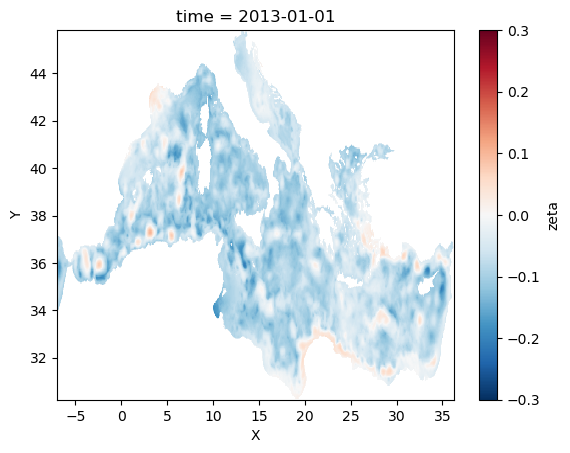

In [23]:
sla_1.plot(cmap=plt.cm.RdBu_r,vmin=-0.3,vmax=0.3)

### Compute geostrophic velocities from SLA

#### changement de coordonnes pour faire des gradients

In [24]:
#on attribue des coordonnes en m pour calculer les gradients
sla2=sla.assign_coords({'X':ds3.xgrid[1,:],'Y':ds3.ygrid[:,1]})

In [25]:
#sla_aviso=ds_aviso.sla
#sla_aviso=sla_aviso.compute()
#sla_aviso.mean('time').plot()

In [26]:
#compute gradients
ugeos=-sla2.differentiate('Y')
vgeos=sla2.differentiate('X')

In [27]:
#on rechange dans le sens initial pour avoir des coordonnes geographiques
ugeos=ugeos.assign_coords({'X':sla.X,'Y':sla.Y})
vgeos=vgeos.assign_coords({'X':sla.X,'Y':sla.Y})

#### on regrille le modele toute les 6h

In [28]:
%%time
ugeos_croco=ugeos.resample(time="6H").mean()
vgeos_croco=vgeos.resample(time="6H").mean()


CPU times: user 19.3 s, sys: 4.28 s, total: 23.6 s
Wall time: 24 s


#### on multiplie par g/f pour avoir une vitesse geostrophique

In [29]:
ugeos_croco*=-grav/ds3.f.data[np.newaxis,:,:]
vgeos_croco*=-grav/ds3.f.data[np.newaxis,:,:]

In [30]:
ugeos_croco=ugeos_croco.where(ds3.mask==1)
vgeos_croco=vgeos_croco.where(ds3.mask==1)

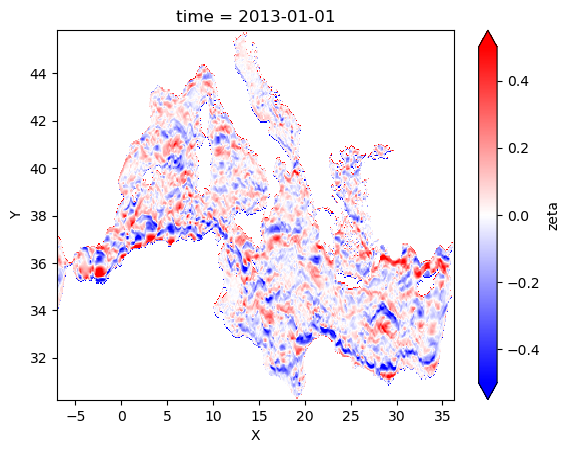

In [31]:
ugeos_croco.sel(time=tsl).plot(vmin=-0.5,vmax=0.5,cmap="bwr")

### READ AVISO

In [32]:
list_aviso=glob.glob('/home/shom_simuref/CROCO/ODC/DATA/ALTI/AVISO/201[2-3]/*.nc')
#read AVISO grid
ds_aviso_grd=xr.open_dataset(list_aviso[0])
dy_aviso,dx_aviso=area(ds_aviso_grd.latitude,ds_aviso_grd.longitude,return_grid=True)

#### get Croco time bounds

In [33]:

time_bnds=slice(ugeos.time[0],ugeos.time[-1])

#### Load AVISO

In [34]:
%%time
ch={"time":-1,"longitude":-1,"latitude":-1}
ds_aviso=xr.open_mfdataset(list_aviso,chunks=ch,
                          combine="by_coords",
                          data_vars='minimal', coords='minimal', compat='override')
ds_aviso=ds_aviso.chunk(ch)

CPU times: user 12.1 s, sys: 704 ms, total: 12.9 s
Wall time: 27.9 s


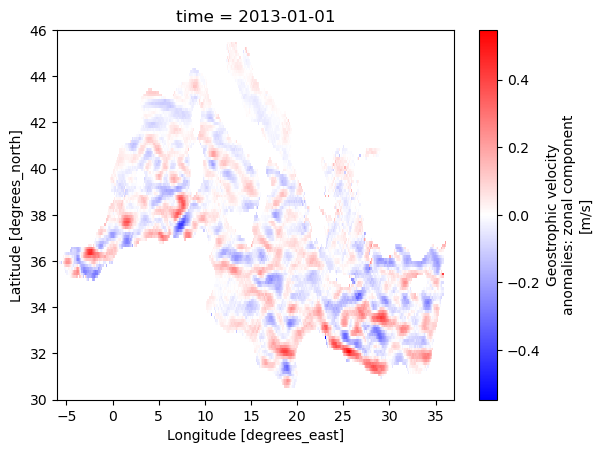

In [35]:
#control plot
ds_aviso.ugosa.sel(time="2013-01-01").plot(cmap='bwr')

#### Select Aviso on the same time bounds that Croco

In [36]:
ds_aviso=ds_aviso.sel(time=time_bnds)

#### Compute (load in memory here) Aviso

In [37]:
%%time
ugeos_aviso=ds_aviso['ugosa'].compute()
vgeos_aviso=ds_aviso['vgosa'].compute()


CPU times: user 3.3 s, sys: 388 ms, total: 3.69 s
Wall time: 5.29 s


In [58]:
#%%time
#zetamin=ds.zeta.min().compute()
#zetamax=ds.zeta.max().compute()

CPU times: user 12.9 s, sys: 0 ns, total: 12.9 s
Wall time: 4min 5s


### Interp CROCO to aviso time

In [38]:
%%time
ugeos_croco2=ugeos_croco.interp(time=ugeos_aviso.time.data,method="linear").compute()
vgeos_croco2=vgeos_croco.interp(time=ugeos_aviso.time.data,method="linear").compute()

CPU times: user 2.46 s, sys: 4.26 s, total: 6.72 s
Wall time: 6.82 s


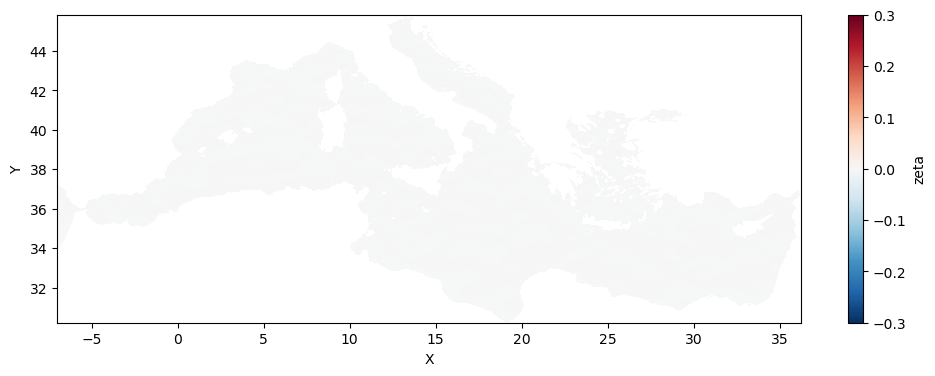

In [39]:
fig, ax = plt.subplots(figsize=(12, 4))
ugeos_croco.mean('time').plot(cmap=plt.cm.RdBu_r,ax=ax,vmin=-0.3,vmax=0.3)

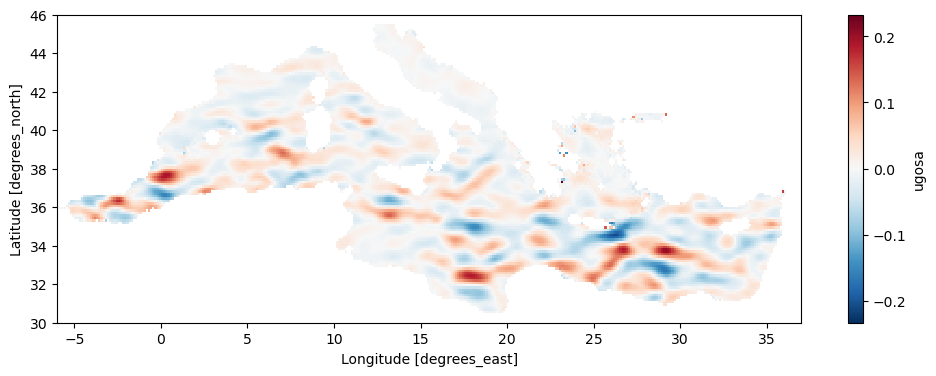

In [46]:
fig, ax = plt.subplots(figsize=(12, 4))
pp=ugeos_aviso.mean('time').plot(ax=ax)

### SET FILTERS FUNCTIONS

#### WRAPPER FOR SCIPY FUNCTION

In [60]:
def butter_filt(x,order_butter,Tc,fs):
    #data are in days so Tc must be in days
    #TC in  days = cut off frequency
    # fs in days = sampling frequency of x
    fc=2/Tc
    b, a = signal.butter(order_butter, fc, 'low', fs=fs, output='ba')
    # Check NA values
    co = np.count_nonzero(~np.isnan(x))
    #if co < 4: # If fewer than 4 observations return -9999
    #    return np.empty(x.shape)
    #else:
    return signal.filtfilt(b, a, x)


#### WRAPPER FOR XARRAY FUNCTION

In [61]:
def filtfilt_butter(x,Tc,fs,order_butter,dim='time'):
 # x ...... xr data array
 # dims .... dimension aong which to apply function    
 filt= xr.apply_ufunc(
     butter_filt,  # first the function
     x,# now arguments in the order expected by 'butter_filt'
     order_butter,  # argument 1
     Tc, # arugment 2
     fs,  # argument 3
     input_core_dims=[["time"], [], [],[]],  # list with one entry per arg
     output_core_dims=[["time"]],  # returned data has 3 dimension
     exclude_dims=set(("time",)),  # dimensions allowed to change size. Must be a set!
     vectorize=True,  # loop over non-core dims
     dask="parallelized",
     output_dtypes=[x.dtype],
     )

 return filt

#### PARAMETERS OF THE FILTER

In [62]:
Tc=100 #frequence de coupure en jours
fs=1 #periode d'échantillonage en jours
order_butter=4

#### Function that return filetered components

In [63]:
def get_filtered(u,v):
    u_low=filtfilt_butter(u,Tc,fs,order_butter,dim="time")
    v_low=filtfilt_butter(v,Tc,fs,order_butter,dim="time")
    u_low['time']=u.time
    v_low['time']=v.time
    u_low=u_low.transpose(*u.dims)
    v_low=v_low.transpose(*v.dims)
    u_high=u-u_low
    v_high=v-v_low
    return u_low,v_low,u_high,v_high
    

In [64]:
%%time
u_aviso_l,v_aviso_l,u_aviso_h,v_aviso_h=get_filtered(ugeos_aviso,vgeos_aviso)
u_croco_l,v_croco_l,u_croco_h,v_croco_h=get_filtered(ugeos_croco2,vgeos_croco2)


CPU times: user 4min 32s, sys: 3.48 s, total: 4min 35s
Wall time: 4min 38s


#### Function that compute Eke from U,V
##### EKE=g2/4f2 * (u'2+v'2) le g/f est déjà dans les composantes U' et V'

In [65]:
# en cm.s-1 pour comparer avec rapport Adetoc (le 0.5 est une erreur mais present dans les figures du rapport)
def get_eke(u_l,v_l,u_h,v_h):
    eke_l=100*N.sqrt(0.5*(u_l**2+v_l**2))
    eke_h=100*N.sqrt(0.5*(u_h**2+v_h**2))
    return eke_l,eke_h
# en m2.s-2
#def get_eke(u_l,v_l,u_h,v_h):
#    eke_l=u_l**2+v_l**2
#    eke_h=u_h**2+v_h**2
#    return eke_l,eke_h

In [66]:
#EKE low et high
eke_aviso_l,eke_aviso_h=get_eke(u_aviso_l,v_aviso_l,u_aviso_h,v_aviso_h)
eke_croco_l,eke_croco_h=get_eke(u_croco_l,v_croco_l,u_croco_h,v_croco_h)


In [67]:
#EKE global (low+high)
#en cm.s-1
eke_croco=100*N.sqrt(0.5*(ugeos_croco2**2+vgeos_croco2**2))
eke_aviso=100*N.sqrt(0.5*(ugeos_aviso**2+vgeos_aviso**2))

#en m2.s-2
#eke_croco=N.sqrt(ugeos_croco2**2+vgeos_croco2**2)
#eke_aviso=N.sqrt(ugeos_aviso**2+vgeos_aviso**2)

In [68]:
#%%time
#ugeos_low=filtfilt_butter(ugeos_aviso,Tc,fs,order_butter,dim="time")
#ugeos_high=ugeos-ugeos_low
#ugeos_low[100,100,:].plot()
#sans apply_ufunc
#test2=butter_filt(ugeos_aviso[:,100,100],order_butter,Tc,fs)
#plt.plot(test2)

### PLOTS

In [69]:
def get_minmax(aviso,croco):
    print("croco",croco.min().data,croco.max().data)
    print("aviso",aviso.min().data,aviso.max().data)


In [70]:
get_minmax(eke_aviso,eke_croco)

croco 0.000847563383380055 558.5315217244956
aviso 0.0 91.00112636665548


In [71]:
import matplotlib.colors as colors
norm=colors.LogNorm(vmin=1e-4,vmax=5e-2)
norm=colors.LogNorm(vmin=1e-2,vmax=50)

#### CONTROL PLOTS WITHOUT CARTOPY

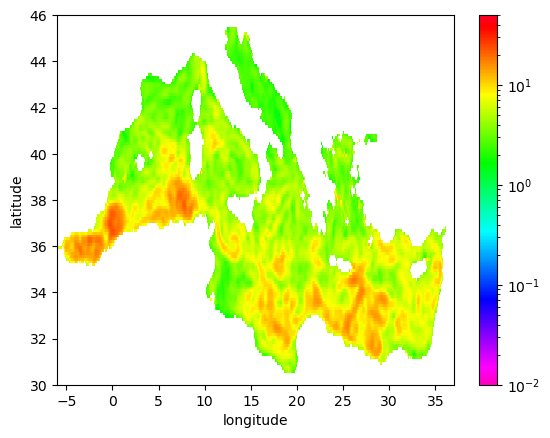

In [72]:
eke_aviso_l.mean('time').plot(cmap=plt.cm.gist_rainbow_r,norm=norm)

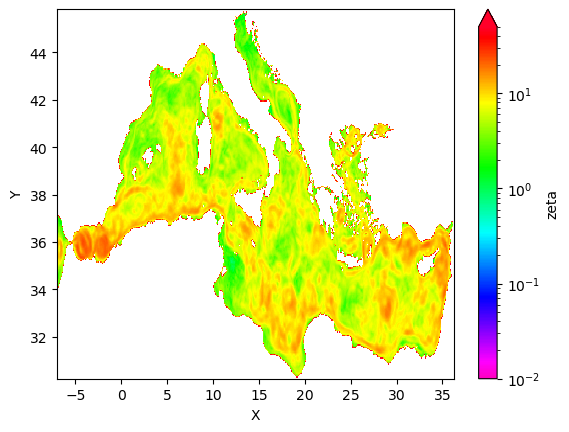

In [73]:
eke_croco_l.mean('time').plot.pcolormesh(cmap=plt.cm.gist_rainbow_r,norm=norm)

#### SET PROJECTIONS TO USE CARTOPY

In [74]:
import cartopy.crs as ccrs
from cartopy.feature import ShapelyFeature
import cartopy.feature as cfeature

In [75]:
proj=ccrs.LambertConformal(central_latitude=38,central_longitude=15)
lon=eke_aviso_l.longitude
lat=eke_aviso_l.latitude
kw_cb=dict(extend="neither")

#### GENERIC FUNCTION TO PLOT THE DATA

In [76]:
def plot_data(lon,lat,data,ax,name,filt,season,**kwargs_plot):
 #fig,ax=plt.subplots(1,1,figsize=(10,8),subplot_kw=dict(projection=proj))
 ax.set_extent([-7,36,30,45],crs=ccrs.PlateCarree())
 ax.coastlines()
 ax.add_feature(cfeature.LAND, zorder=1, edgecolor='k')
 ax.set_title(f'{name} - {season} mean')
 cf=ax.pcolormesh(lon,lat,data,**kwargs_plot)
 #plt.savefig(f'EKE_{name}_{filt}_{season}.png')
 #cbar
 return ax,cf

In [77]:
datas=['aviso','croco']
filters=['low','high']
seasons=["DJF", "MAM", "JJA", "SON"]

#### GENERIC FUNCTION TO PLOT ALL SEASONS IN ONE PLOT GIVEN FREQUENCY

In [146]:
def make_figure(aviso,croco,filt,vmin,vmax):

 norm=colors.LogNorm(vmin=vmin,vmax=vmax)   
 kwargs_plot=dict(norm=norm,transform=ccrs.PlateCarree(),cmap=plt.cm.gist_ncar)
 fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(14, 12),subplot_kw=dict(projection=proj))
 plt.suptitle(f'EKE {filt} Freq (cutoff={Tc} days) {date_start}->{date_end}') 
 for i, season in enumerate(("YEAR","DJF", "MAM", "JJA", "SON")):
     #print(season)
     data1=aviso
     data2=croco
     if (season=="YEAR"):
         data1=data1.mean('time')
         data2=data2.mean('time')
     else:
         data1=data1.groupby('time.season').mean('time').sel(season=season)
         data2=data2.groupby('time.season').mean('time').sel(season=season)
     ax,cf=plot_data(data1.longitude,data1.latitude,data1,axes[i,0],"aviso",filt,season,**kwargs_plot)
     ax,cf=plot_data(data2.X,data2.Y,data2,axes[i,1],"croco",filt,season,**kwargs_plot) 
 #cbar = fig.colorbar(cf, ax=axes.ravel().tolist(), shrink=0.7,label='$m^2$.$s^-2$')
 cbar = fig.colorbar(cf, ax=axes.ravel().tolist(), shrink=0.7,label='$cm$.$s^-1$')

 return fig

In [147]:
get_minmax(eke_aviso_l,eke_croco_l)

croco 0.0006029959162151201 192.3656099789513
aviso 0.002228543022646149 52.36813484043892


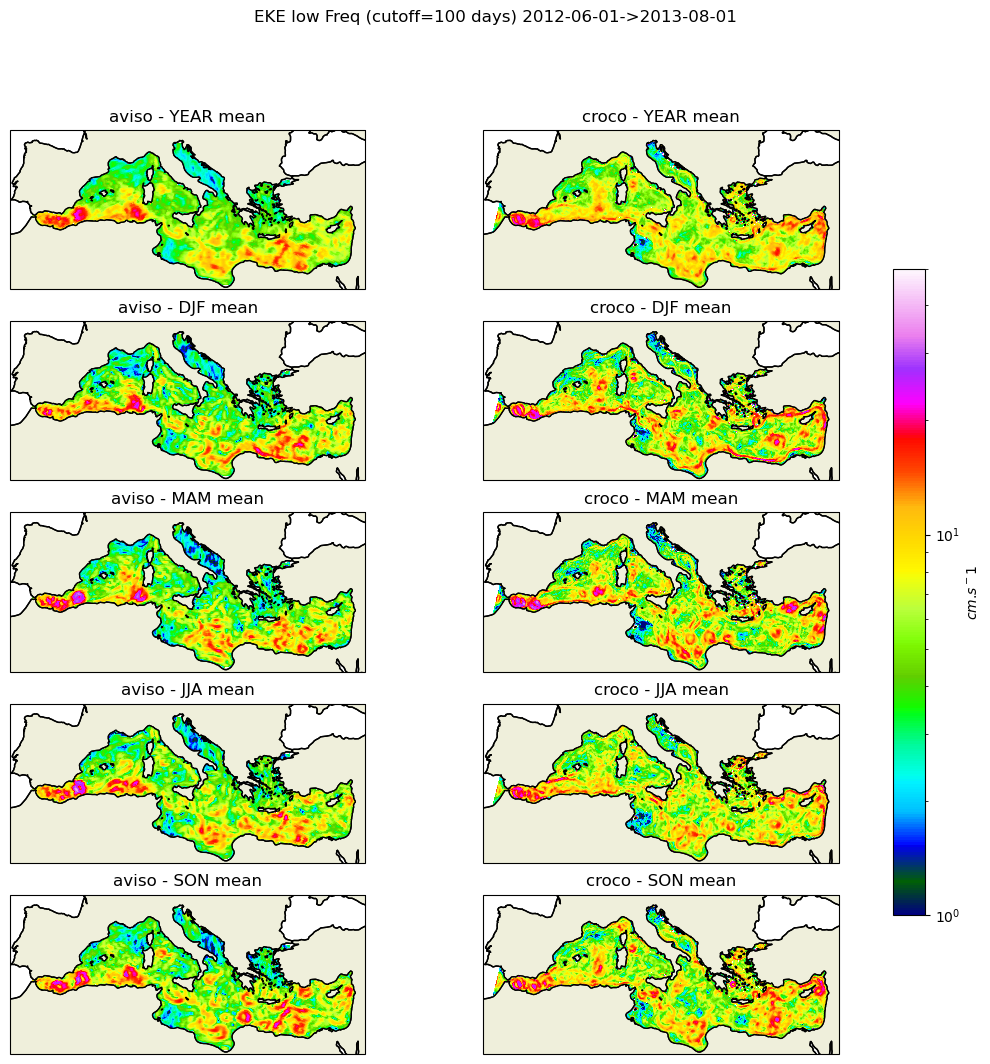

In [148]:
#fig_low=make_figure(eke_aviso_l,eke_croco_l,"low",1e-4,1e-1)
fig_low=make_figure(eke_aviso_l,eke_croco_l,"low",1,50)

fig_low.savefig('eke_low_pass.png')

In [149]:
get_minmax(eke_aviso_h,eke_croco_h)

croco 8.079912308416298e-05 453.0415986678146
aviso 0.001477820265338066 37.14392102696245


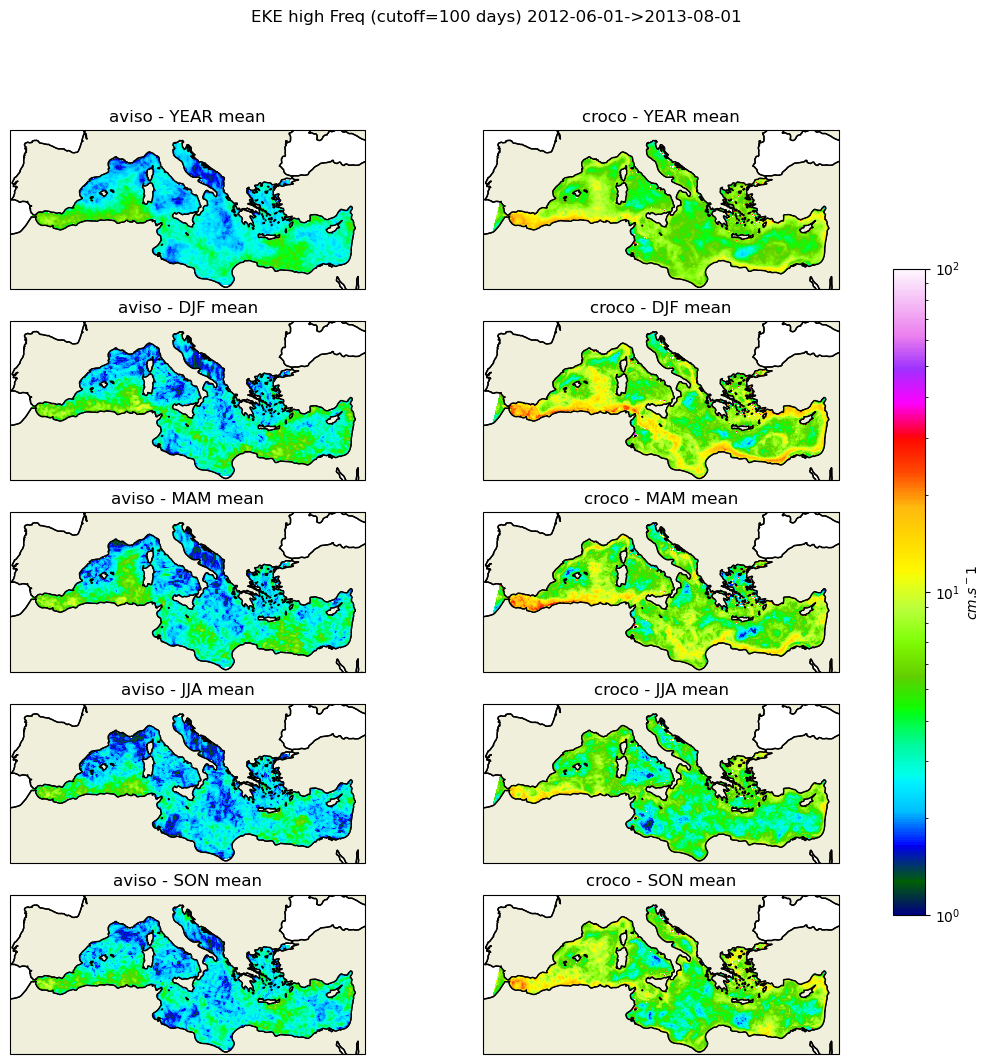

In [150]:
#fig_high=make_figure(eke_aviso_h,eke_croco_h,"high",1e-4,5e-1)
fig_high=make_figure(eke_aviso_h,eke_croco_h,"high",1,100)

fig_high.savefig('eke_high_pass.png')

In [151]:
get_minmax(eke_aviso,eke_croco)

croco 0.000847563383380055 558.5315217244956
aviso 0.0 91.00112636665548


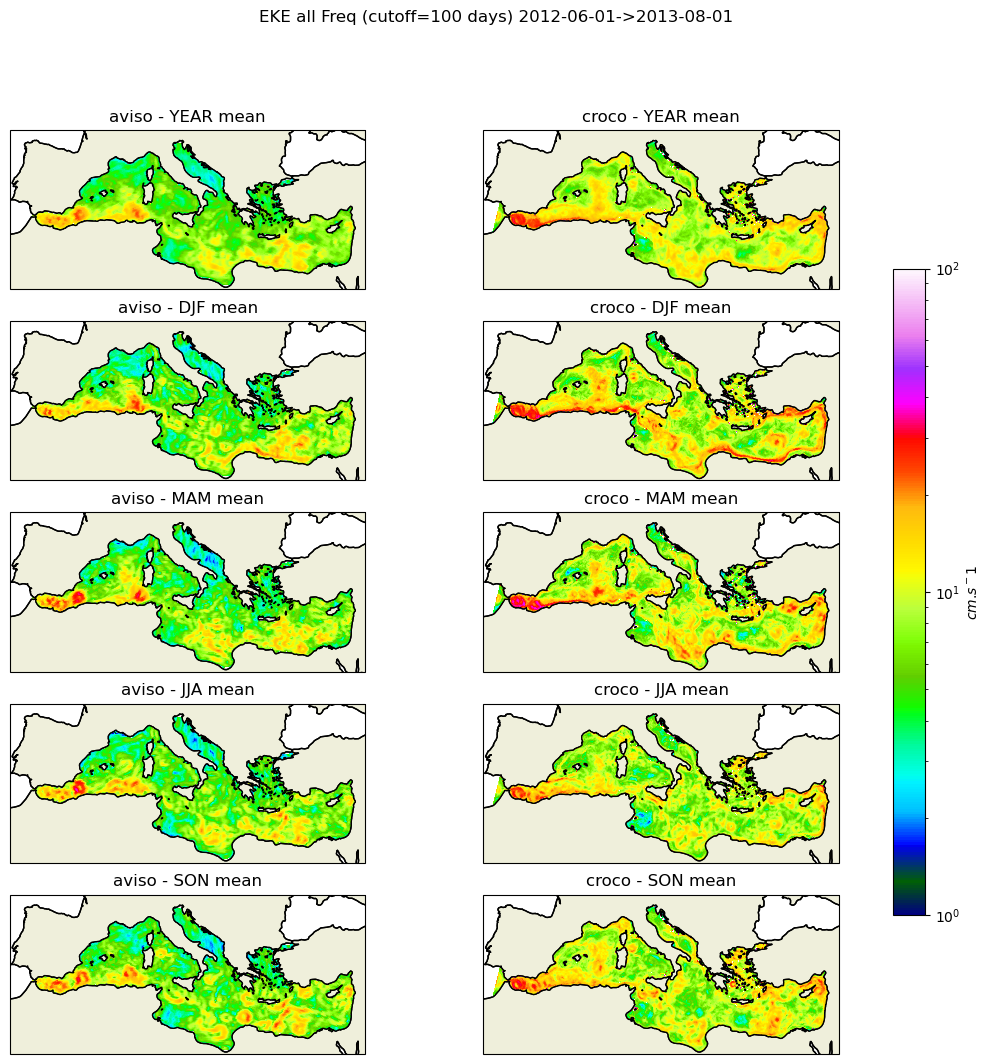

In [152]:
#fig_all=make_figure(eke_aviso,eke_croco,"all",1e-4,5e-1)
fig_all=make_figure(eke_aviso,eke_croco,"all",1,100)

fig_all.savefig('eke_all_pass.png')

### PLOT BY BASINS

### Read shapefile

In [153]:
basins_shp='/home/shom_simuref/CROCO/ODC/POSTPROC/DATA/shapefiles/med_sub_basins_2.shp'

In [154]:
### read basins shape

In [155]:
shp=shpreader.Reader(basins_shp)
shape_feature = ShapelyFeature(shp.geometries(),
                                ccrs.PlateCarree(),facecolor=None)

<AxesSubplot: >

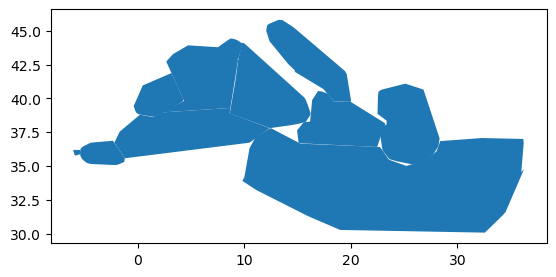

In [156]:
gdf=gpd.read_file(basins_shp)
gdf.plot()

#### Get basins list

In [157]:
gdf=gdf.set_index('name')
basins_names=gdf.index

In [158]:
print(basins_names)

Index(['Strait of Gibraltar', 'Alboran Sea', 'Ionian Sea', 'Tyrrhenian Sea',
       'Adriatic Sea', 'Levantine Sea', 'Aegean Sea', 'Balearic Sea',
       'South-Western Basin', 'North-Western Basin'],
      dtype='object', name='name')


#### Get grid from Croco and Aviso

In [134]:
lon,lat=eke_aviso.longitude,eke_aviso.latitude
lon_aviso,lat_aviso=N.meshgrid(lon,lat)
lon,lat=eke_croco.X,eke_croco.Y
lon_croco,lat_croco=N.meshgrid(lon,lat)

#### Transpose data to have uniform data

In [135]:
eke_aviso_l=eke_aviso_l.transpose("time","latitude","longitude")
eke_aviso_h=eke_aviso_h.transpose("time","latitude","longitude")
eke_croco_l=eke_croco_l.transpose("time","Y","X")
eke_croco_h=eke_croco_h.transpose("time","Y","X")

In [136]:
name='Levantine Sea'
#select area of interest
area=gdf.loc[gdf.index==name]
mask_aviso=shapely.vectorized.contains(area.dissolve().geometry.item(),lon_aviso,lat_aviso)
mask_croco=shapely.vectorized.contains(area.dissolve().geometry.item(),lon_croco,lat_croco)

In [137]:
eke_aviso_area=eke_aviso_l.where(mask_aviso)
eke_aviso_area2=eke_aviso_area.copy()
#eke_aviso_area2[:]=N.sqrt(eke_aviso_area.data)

In [138]:
#eke_aviso_area2[:]*=100.
eke_aviso_area2.mean(dim=["latitude","longitude"]).plot()

#### Function to format Data

In [139]:
def format_date(ax):
    return ax.xaxis.set_major_formatter(
           mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))

#### Function to plot by frequency

In [165]:
def plot_all(aviso,croco,freq):
    basins_names2=basins_names.tolist()[:]
    #fig, axes = plt.subplots(nrows=len(basins_names2), sharex=True,sharey=False,ncols=1, figsize=(12, 12))
    fig, axes = plt.subplots(nrows=5,ncols=2, sharex=True,sharey=False, figsize=(12, 12))

    for i,name in enumerate(basins_names2):
        print(i,name)
        
        #select area of interest
        area=gdf.loc[gdf.index==name]
        
        #get the mask from longitude and latitude : intersection of area and the domain
        mask_aviso=shapely.vectorized.contains(area.dissolve().geometry.item(),lon_aviso,lat_aviso)
        mask_croco=shapely.vectorized.contains(area.dissolve().geometry.item(),lon_croco,lat_croco)
        
        #apply the mask to the data and do an average over the horizontal grid
        eke_aviso_area=aviso.where(mask_aviso).mean(dim=["latitude","longitude"])
        eke_croco_area=croco.where(mask_croco).mean(dim=["X","Y"])
        #ax=axes[i]
        ax=axes.flatten()[i]
        #do the plot
        ax.plot(eke_aviso_area.time,eke_aviso_area.data,label="Aviso")
        ax.plot(eke_croco_area.time,eke_croco_area.data,label="Croco")
        
        ### custom labels ###
        plt.xlabel('');plt.ylabel('')
        #get min,max to set clean limits
        min1,max1=eke_aviso_area.data.min(),eke_aviso_area.data.max()
        #min2,max2=eke_aviso_area.data.min(),eke_aviso_area.data.max()

        min2,max2=eke_croco_area.min(),eke_croco_area.max()
        if i == 0: 
            ax.legend()
        #ax.set_ylabel('$m^2$.$s^-2$')
        ax.set_ylabel('$cm$.$s^-1$')
        ax.set_title('%s'%(name))
        ax.set_ylim((min(min1,min2),max(max1,max2)))
        ax.yaxis.set_minor_locator(MaxNLocator(1))
        if i==len(basins_names2)-1: 
            ax=format_date(ax)
    plt.suptitle(f'EKE {freq} - Cutoff={Tc} days')
    plt.tight_layout()
    return fig

In [166]:
fig_ts_low=plot_all(eke_aviso_l,eke_croco_l,"low")

0 Strait of Gibraltar
1 Alboran Sea
2 Ionian Sea
3 Tyrrhenian Sea
4 Adriatic Sea
5 Levantine Sea
6 Aegean Sea
7 Balearic Sea
8 South-Western Basin
9 North-Western Basin


In [167]:
fig_ts_low.savefig('eke_time_serie_low_pass.png')

0 Strait of Gibraltar
1 Alboran Sea
2 Ionian Sea
3 Tyrrhenian Sea
4 Adriatic Sea
5 Levantine Sea
6 Aegean Sea
7 Balearic Sea
8 South-Western Basin
9 North-Western Basin


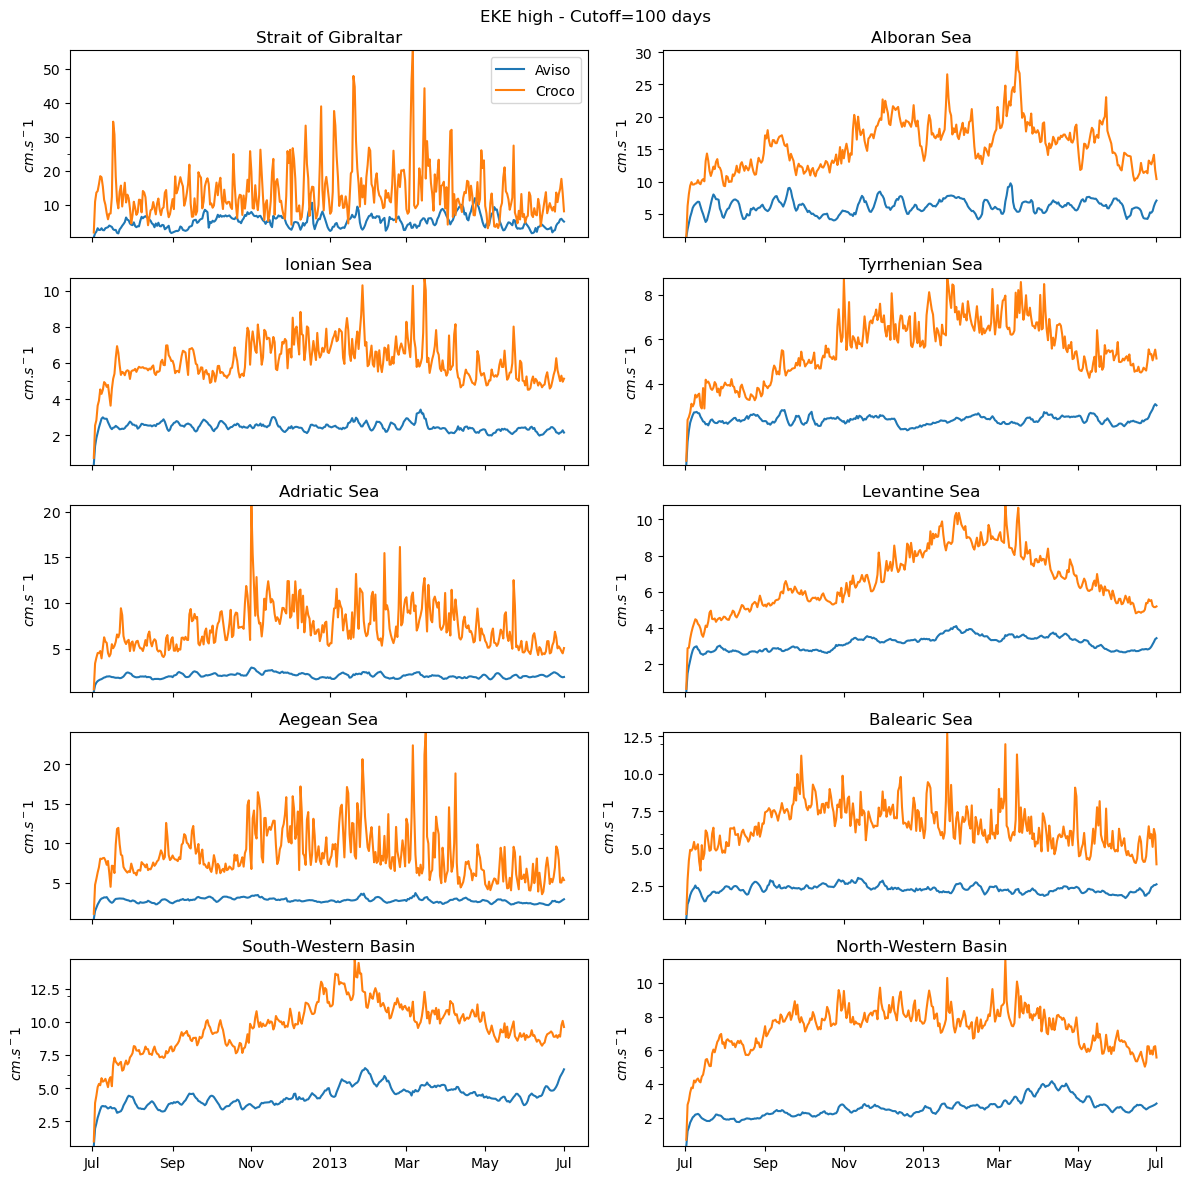

In [168]:
fig_ts_high=plot_all(eke_aviso_h,eke_croco_h,"high")

In [169]:
fig_ts_high.savefig('eke_time_serie_high_pass.png')

0 Strait of Gibraltar
1 Alboran Sea
2 Ionian Sea
3 Tyrrhenian Sea
4 Adriatic Sea
5 Levantine Sea
6 Aegean Sea
7 Balearic Sea
8 South-Western Basin
9 North-Western Basin


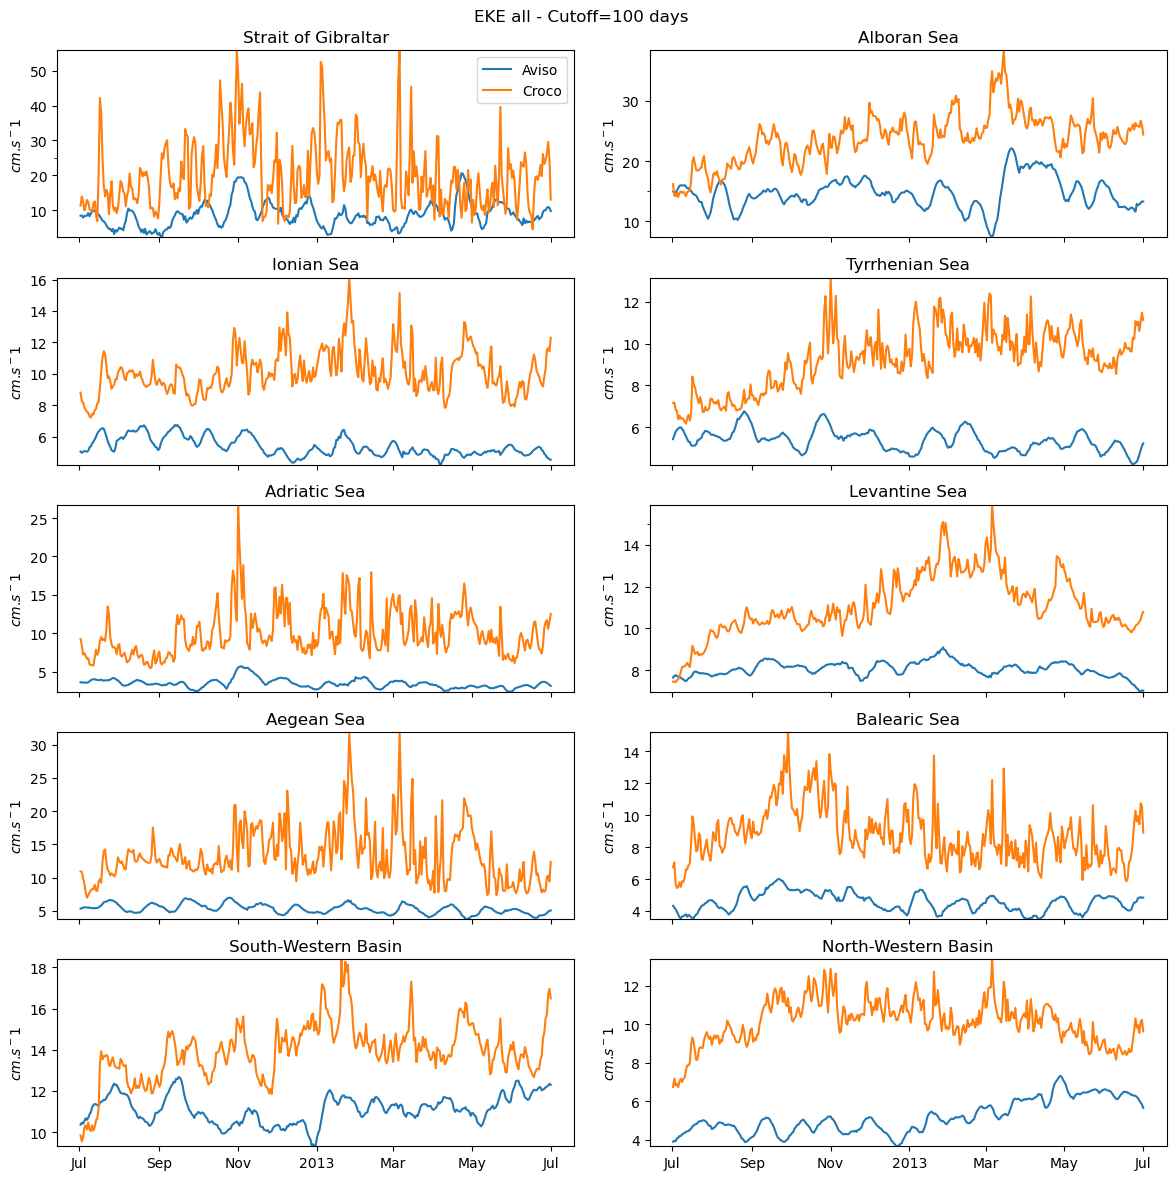

In [170]:
fig_ts_all=plot_all(eke_aviso,eke_croco,"all")
fig_ts_all.savefig('eke_time_serie_all_pass.png')